## Imports

In [1]:
import os
import numpy as np
import torch
import albumentations as A
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as cp
import cv2

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from matplotlib import pyplot as plt

## Dataset

[1 2 3]


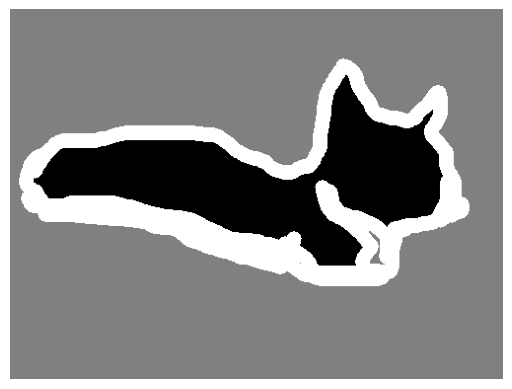

In [2]:
# Load a grayscale image using OpenCV
image = cv2.imread('data/annotations/trimaps/Bengal_10.png', cv2.IMREAD_GRAYSCALE)
print(np.unique(image))

# Display the grayscale image using matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')  # Optionally, turn off axis labels
plt.show()

In [3]:
color_map = [1, 2, 3] #[outline, background, ground_truth, object(cat or dog)]

In [4]:
train_transform = A.Compose(
    [
        A.Resize(width=130, height=130),
        A.RandomCrop(width=128, height=128),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [5]:
val_transform = A.Compose(
        [
            A.Resize(width=130, height=130),
            A.CenterCrop(width=128, height=128),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [6]:
def process_mask(mask, colormap, class_name):
    output_mask = []
    mask = np.array(mask)

    for color in colormap:
        cmap = np.all(np.equal(mask, color), axis=-1)
        output_mask.append(cmap)

    # To add a mask for class that have no value in image
    extra_mask = np.zeros((128, 128)) 

    if class_name == "dog":
        output_mask.insert(2, extra_mask)    

    else:
        output_mask.append(extra_mask)
           
    output_mask = np.stack(output_mask, axis=-1)
    
    output_mask = torch.tensor(output_mask).float().permute(2, 0, 1)
    
    return output_mask

In [7]:
class CarvanaDataset(Dataset):
    
    def __init__(self, image_dir, mask_dir, color_map, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.color_map = color_map

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = np.expand_dims(mask, axis=-1)

        if self.images[index][0].isupper():
            class_name = 'cat'
        
        else:
            class_name = 'dog'

        if self.transform is not None:   
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = process_mask(mask, self.color_map, class_name)      
    
        return image, mask

In [8]:
image_dir = 'data/images/'
mask_dir = 'data/annotations/trimaps/'

In [9]:
train_dataset = CarvanaDataset(image_dir, mask_dir, transform=train_transform, color_map=color_map)
valid_dataset = CarvanaDataset(image_dir, mask_dir, transform=val_transform, color_map=color_map)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, shuffle=True)

In [11]:
print('image_shape:', train_dataset[500][0].shape)
print('mask_shape:', train_dataset[500][1].shape)

image_shape: torch.Size([3, 128, 128])
mask_shape: torch.Size([4, 128, 128])


## Model

In [12]:
class DoubleConv(nn.Module):
        
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.duble_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            
        )

    def forward(self, input):
        return self.duble_conv(input)

In [13]:
class U_NET(nn.Module):

    def __init__(self, in_channels, out_channels, features=[64, 128, 256, 512]):
        super().__init__()

        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels=in_channels, out_channels=feature))
            in_channels = feature
        
        for feature in reversed(features):

            self.ups.append(
                nn.ConvTranspose2d(in_channels=feature*2, out_channels=feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(in_channels=feature*2, out_channels=feature))
             
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        
    def forward(self, x):

        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] #reverse

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]

            if x.shape != skip.shape:
                x = TF.resize(x, size=skip.shape[2:])

            concat_skip = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            

        return self.final_conv(x)

In [14]:
model = U_NET(3, 4)
model

U_NET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), str

## Train

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [16]:
model = model.to(device)

In [17]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def cal_dice_IOU(y_pred, y, color_map):
    smooth = 1.0
    dice = 0.0
    IOU = 0.0

    y_pred = y_pred.argmax(dim=1)
    y = y.argmax(dim=1)

    for i in range(len(color_map)+1):
         intersection = torch.sum((y_pred == i) * (y==i))
         y_area = torch.sum((y == i))
         y_pred_area = torch.sum((y_pred == i))
         combined_area = y_pred_area + y_area

         IOU += (intersection +smooth) / (combined_area - intersection + smooth)
         
         dice += (2 * intersection +smooth) / (combined_area + smooth)    

    return dice / len(color_map) , IOU / len(color_map)

In [19]:
def train(train_loader, valid_loader, model, epochs, optimizer, loss, device, metric_fn, color_map):

    for epoch in range(epochs):
        val_IOU = 0.0
        val_dice = 0.0

        model.train()

        for image, mask in train_loader:
            image = image.to(device)
            mask = mask.to(device)
            
            pred_mask = model(image)
            optimizer.zero_grad()
                       
            with torch.set_grad_enabled(True):
                mask_loss = loss(pred_mask, mask)
                mask_loss.backward()
                optimizer.step()
                
            torch.cuda.empty_cache()

        model.eval()

        for val_image, val_mask in valid_loader:
            val_image = val_image.to(device)
            val_mask = val_mask.to(device)

            pred_val_mask = model(val_image)

            val_dice += metric_fn(pred_val_mask, val_mask, color_map)[0]
            val_IOU += metric_fn(pred_val_mask, val_mask, color_map)[1]

            torch.cuda.empty_cache()         

        print(f'epopch: {epoch} val_dice: {val_dice / len(valid_loader)} \n val_IOU: {val_IOU / len(valid_loader)}')

In [20]:
train(train_loader, valid_loader, model, 15, optimizer, loss, device, cal_dice_IOU, color_map)

epopch: 0 val_dice: 0.673474133014679 
 val_IOU: 0.5527303814888
epopch: 1 val_dice: 0.7075714468955994 
 val_IOU: 0.5937411189079285
epopch: 2 val_dice: 0.7405950427055359 
 val_IOU: 0.6266646981239319
epopch: 3 val_dice: 0.7506635785102844 
 val_IOU: 0.6426700949668884
epopch: 4 val_dice: 0.7619498372077942 
 val_IOU: 0.6549878716468811
epopch: 5 val_dice: 0.7678141593933105 
 val_IOU: 0.6563963890075684
epopch: 6 val_dice: 0.8468017578125 
 val_IOU: 0.7113038301467896
epopch: 7 val_dice: 0.8431535363197327 
 val_IOU: 0.7130354642868042
epopch: 8 val_dice: 0.8638920783996582 
 val_IOU: 0.7285492420196533
epopch: 9 val_dice: 0.9055604338645935 
 val_IOU: 0.7643666863441467
epopch: 10 val_dice: 0.9391114115715027 
 val_IOU: 0.7927970886230469
epopch: 11 val_dice: 0.9498917460441589 
 val_IOU: 0.8012661337852478
epopch: 12 val_dice: 0.9555491209030151 
 val_IOU: 0.8108357191085815
epopch: 13 val_dice: 0.9673991203308105 
 val_IOU: 0.8231359720230103
epopch: 14 val_dice: 0.98637461662292

In [21]:
path = 'saved_model.pth'
torch.save(model, path)

## Test

In [22]:
path = 'saved_model.pth'
loaded_model = torch.load(path).to(device)
loaded_model.eval()

U_NET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (duble_conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), str

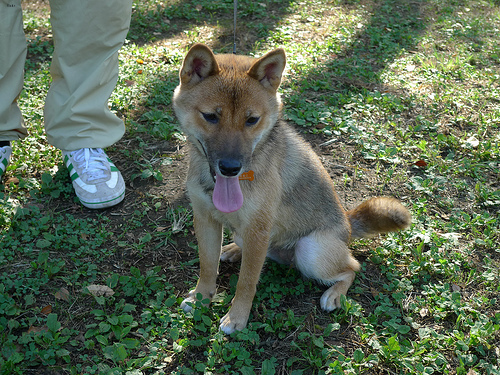

In [33]:
test_image = Image.open('data/images/shiba_inu_115.jpg')
test_image

In [34]:
test_image = np.array(test_image.convert("RGB"))
augmentations = val_transform(image=test_image)
test_image = augmentations["image"]
test_image = torch.unsqueeze(test_image, dim=0).to(device)

In [35]:
test_image.shape

torch.Size([1, 3, 128, 128])

In [36]:
pred = loaded_model(test_image).squeeze(0)
pred = pred.argmax(dim=0).cpu()
pred.shape

torch.Size([128, 128])

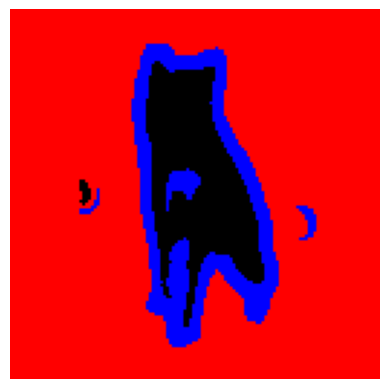

In [37]:
cmap = plt.cm.colors.ListedColormap(['black', 'red', 'green', 'blue'])

# Create an RGB image by mapping tensor values to colors
rgb_image = cmap(pred)

# Display the RGB image using Matplotlib
plt.imshow(rgb_image)
plt.axis('off')  # Optionally, turn off the axis labels
plt.show()